In [2]:
import re
import numpy as np
from sklearn.manifold import TSNE
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
nltk.download('punkt')

# Function to read and preprocess text
def read_and_preprocess(files):
    corpus = []
    for file in files:
        with open(file, 'r') as f:
            for i in range(200):
                line = f.readline().strip().lower()
                if not line:  # Stop if the end of the file is reached before reading num_lines
                    break
                # Remove punctuation
                line = re.sub(r'[^\w\s]', '', line)
                # Tokenize
                tokens = word_tokenize(line)
                corpus.extend(tokens)
    return corpus

# Specify the files for the seven books
files = ['HarryPotter/HP1.txt']
#, 'HarryPotter/HP3.txt', 'HarryPotter/HP4.txt', 'HarryPotter/HP5.txt', 'HarryPotter/HP6.txt', 'HarryPotter/HP7.txt']
# Preprocess the text
corpus = read_and_preprocess(files)


[nltk_data] Downloading package punkt to /home/zachs/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Create vocabulary and mappings
unique_words = list(set(corpus))
word_to_idx = {word: i for i, word in enumerate(unique_words)}
idx_to_word = {i: word for i, word in enumerate(unique_words)}

# Label encoding for corpus
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(corpus)

# One-hot encoding for integer encoded corpus
onehot_encoder = OneHotEncoder(sparse_output=False, categories='auto')
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

In [4]:
# Create training data
def generate_training_data(corpus, word_to_idx, window_size):
    X, y = [], []
    for i in range(len(corpus)):
        target_word = word_to_idx[corpus[i]]
        context_words = []
        for j in range(-window_size, window_size + 1):
            if j == 0 or i + j < 0 or i + j >= len(corpus):
                continue
            context_word = word_to_idx[corpus[i + j]]
            context_words.append(context_word)
        X.extend([target_word] * len(context_words))
        y.extend(context_words)
    return np.array(X), np.array(y)

window_size = 1
X, y = generate_training_data(corpus, word_to_idx, window_size)


In [5]:
# Parameters
vocab_size = len(unique_words)
embedding_dim = 100  # Dimension of the embedding vectors

initializer = tf.keras.initializers.RandomNormal(mean=0.05, stddev=0.05)
# Define the model
input_layer = tf.keras.layers.Input(shape=(1,))
embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1)(input_layer)
hidden_layer = tf.keras.layers.Dense(128, activation=None, kernel_initializer = initializer)(embedding_layer)
dropout_layer = tf.keras.layers.Dropout(0.5)(hidden_layer)
flatten_layer = tf.keras.layers.Flatten()(hidden_layer)
output_layer = tf.keras.layers.Dense(vocab_size, activation='softmax', kernel_initializer = initializer)(flatten_layer)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model.fit(X_train, y_train, epochs=20, batch_size=40, validation_data=(X_test, y_test))

print("Model training completed.")


Epoch 1/20


2024-08-09 14:34:48.998131: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-09 14:34:49.182860: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-09 14:34:49.182919: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-09 14:34:49.186179: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-09 14:34:49.186241: I external/local_xla/xla/stream_executor

1695/1695 [==============================] - 14s 8ms/step - loss: 6.6547 - accuracy: 0.0584 - val_loss: 6.3979 - val_accuracy: 0.0768
Epoch 2/20
1695/1695 [==============================] - 14s 8ms/step - loss: 6.1387 - accuracy: 0.0932 - val_loss: 6.2854 - val_accuracy: 0.0895
Epoch 3/20
1695/1695 [==============================] - 13s 8ms/step - loss: 5.8612 - accuracy: 0.1136 - val_loss: 6.2684 - val_accuracy: 0.0933
Epoch 4/20
1695/1695 [==============================] - 13s 8ms/step - loss: 5.6170 - accuracy: 0.1238 - val_loss: 6.3057 - val_accuracy: 0.0957
Epoch 5/20
1695/1695 [==============================] - 13s 8ms/step - loss: 5.3919 - accuracy: 0.1321 - val_loss: 6.3954 - val_accuracy: 0.0957
Epoch 6/20
1695/1695 [==============================] - 13s 8ms/step - loss: 5.1884 - accuracy: 0.1370 - val_loss: 6.5010 - val_accuracy: 0.0935
Epoch 7/20
1695/1695 [==============================] - 14s 8ms/step - loss: 5.0110 - accuracy: 0.1381 - val_loss: 6.6180 - val_accuracy: 0.0

In [6]:
# Create a model to extract embeddings
embedding_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(index=1).output)
embeddings = embedding_model.get_weights()[0]  # Get the weights of the embedding layer

# Function to get embedding for a word
def get_embedding(word):
    word_idx = word_to_idx[word]
    return embeddings[word_idx]

# Compute similarity between the target word and all other words
def get_most_similar_words(target_word, top_n=10):
    target_embedding = get_embedding(target_word)
    similarities = []
    
    for idx, word in idx_to_word.items():
        if word == target_word:
            continue
        word_embedding = embeddings[idx]
        similarity = cosine_similarity([target_embedding], [word_embedding])[0][0]
        similarities.append((word, similarity))
    
    # Sort by similarity
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# Example usage
target_word = "harry"
top_related_words = get_most_similar_words(target_word, top_n=10)

print(f"Top related words to '{target_word}':")
for word, similarity in top_related_words:
    print(f"{word}: {similarity:.4f}")


Top related words to 'harry':
glumly: 0.4968
politely: 0.4847
urgently: 0.4843
mutely: 0.4392
miserably: 0.4179
fattenin: 0.4069
afterward: 0.4060
definitely: 0.4057
birdwatchers: 0.3859
tearful: 0.3696


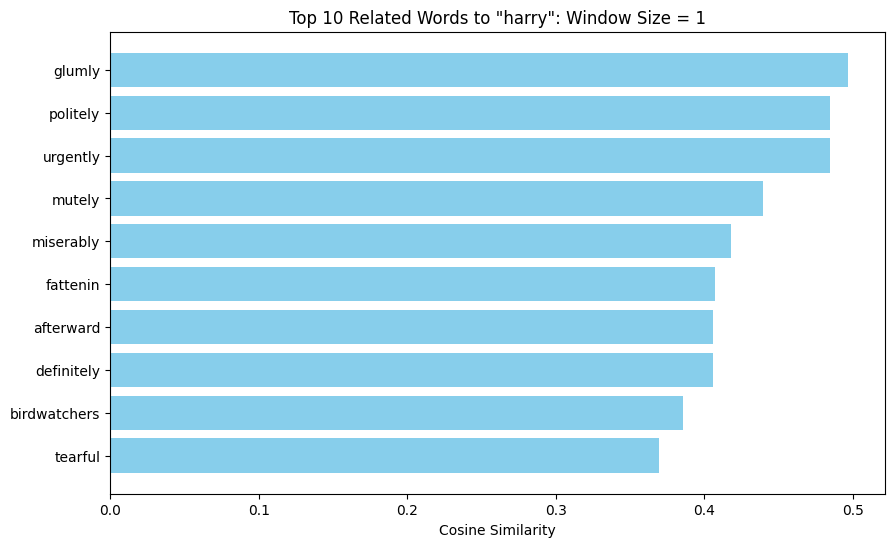

In [7]:
import matplotlib.pyplot as plt

# Plotting the results
words, similarities = zip(*top_related_words)

plt.figure(figsize=(10, 6))
plt.barh(words, similarities, color='skyblue')
plt.xlabel('Cosine Similarity')
plt.title(f'Top 10 Related Words to "{target_word}": Window Size = 1')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest similarity on top
plt.show()


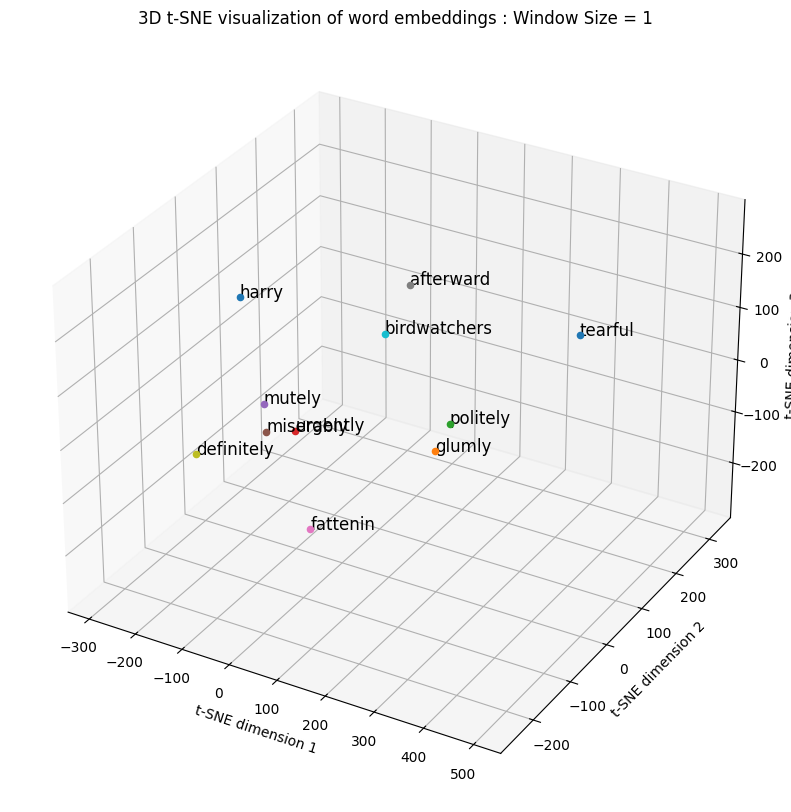

In [8]:
# Prepare data for t-SNE
words = [target_word] + [word for word, _ in top_related_words]
word_embeddings = np.array([get_embedding(word) for word in words])

# Apply t-SNE with adjusted perplexity
perplexity = min(30, len(words) - 1)  # Perplexity should be less than the number of samples
tsne = TSNE(n_components=3, perplexity=perplexity, random_state=42)
word_embeddings_3d = tsne.fit_transform(word_embeddings)

# Plot the t-SNE visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for i, word in enumerate(words):
    ax.scatter(word_embeddings_3d[i, 0], word_embeddings_3d[i, 1], word_embeddings_3d[i, 2])
    ax.text(word_embeddings_3d[i, 0], word_embeddings_3d[i, 1], word_embeddings_3d[i, 2], word, fontsize=12)

ax.set_title('3D t-SNE visualization of word embeddings : Window Size = 1')
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')
ax.set_zlabel('t-SNE dimension 3')
plt.show()

## Increase window size

### Window size = 3

In [9]:
window_size = 3
X, y = generate_training_data(corpus, word_to_idx, window_size)

In [10]:
vocab_size = len(unique_words)
embedding_dim = 100  # Dimension of the embedding vectors

initializer = tf.keras.initializers.RandomNormal(mean=0.05, stddev=0.05)
# Define the model
input_layer = tf.keras.layers.Input(shape=(1,))
embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1)(input_layer)
hidden_layer = tf.keras.layers.Dense(128, activation=None, kernel_initializer = initializer)(embedding_layer)
dropout_layer = tf.keras.layers.Dropout(0.5)(hidden_layer)
flatten_layer = tf.keras.layers.Flatten()(hidden_layer)
output_layer = tf.keras.layers.Dense(vocab_size, activation='softmax', kernel_initializer = initializer)(flatten_layer)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model.fit(X_train, y_train, epochs=20, batch_size=40, validation_data=(X_test, y_test))

print("Model training completed.")


Epoch 1/20


/home/zachs/.local/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


5083/5083 [==============================] - 40s 8ms/step - loss: 6.5927 - accuracy: 0.0481 - val_loss: 6.4724 - val_accuracy: 0.0534
Epoch 2/20
5083/5083 [==============================] - 40s 8ms/step - loss: 6.3742 - accuracy: 0.0562 - val_loss: 6.4075 - val_accuracy: 0.0555
Epoch 3/20
5083/5083 [==============================] - 40s 8ms/step - loss: 6.1995 - accuracy: 0.0617 - val_loss: 6.3989 - val_accuracy: 0.0544
Epoch 4/20
5083/5083 [==============================] - 39s 8ms/step - loss: 6.0266 - accuracy: 0.0638 - val_loss: 6.4251 - val_accuracy: 0.0520
Epoch 5/20
5083/5083 [==============================] - 39s 8ms/step - loss: 5.8735 - accuracy: 0.0633 - val_loss: 6.4794 - val_accuracy: 0.0509
Epoch 6/20
5083/5083 [==============================] - 39s 8ms/step - loss: 5.7500 - accuracy: 0.0621 - val_loss: 6.5285 - val_accuracy: 0.0498
Epoch 7/20
5083/5083 [==============================] - 39s 8ms/step - loss: 5.6558 - accuracy: 0.0605 - val_loss: 6.5892 - val_accuracy: 0.0

In [11]:
embedding_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(index=1).output)
embeddings = embedding_model.get_weights()[0]  # Get the weights of the embedding layer

target_word = "harry"
top_related_words = get_most_similar_words(target_word, top_n=10)

print(f"Top related words to '{target_word}':")
for word, similarity in top_related_words:
    print(f"{word}: {similarity:.4f}")


Top related words to 'harry':
dazed: 0.3465
jell: 0.3217
lend: 0.3004
prodding: 0.2945
jet: 0.2817
agreed: 0.2697
stammering: 0.2607
dumbfounded: 0.2542
crybabies: 0.2515
cmere: 0.2457


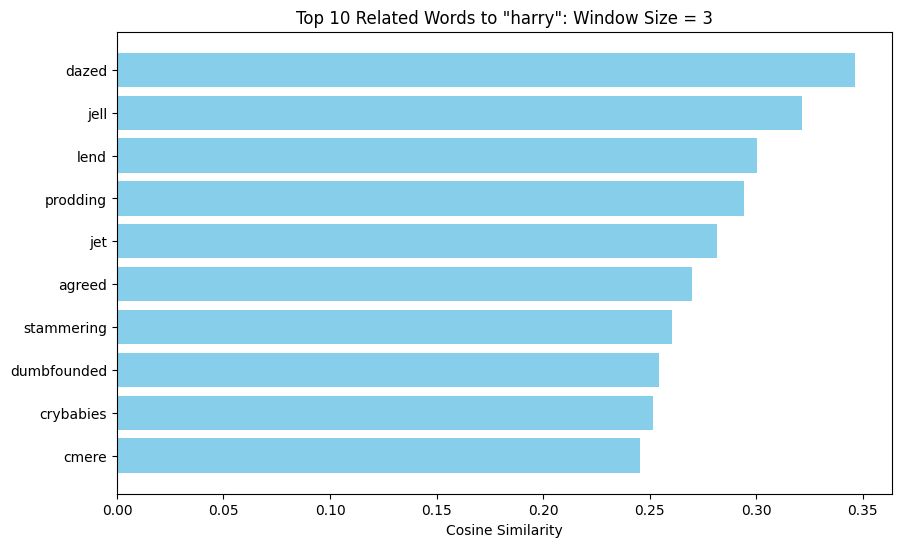

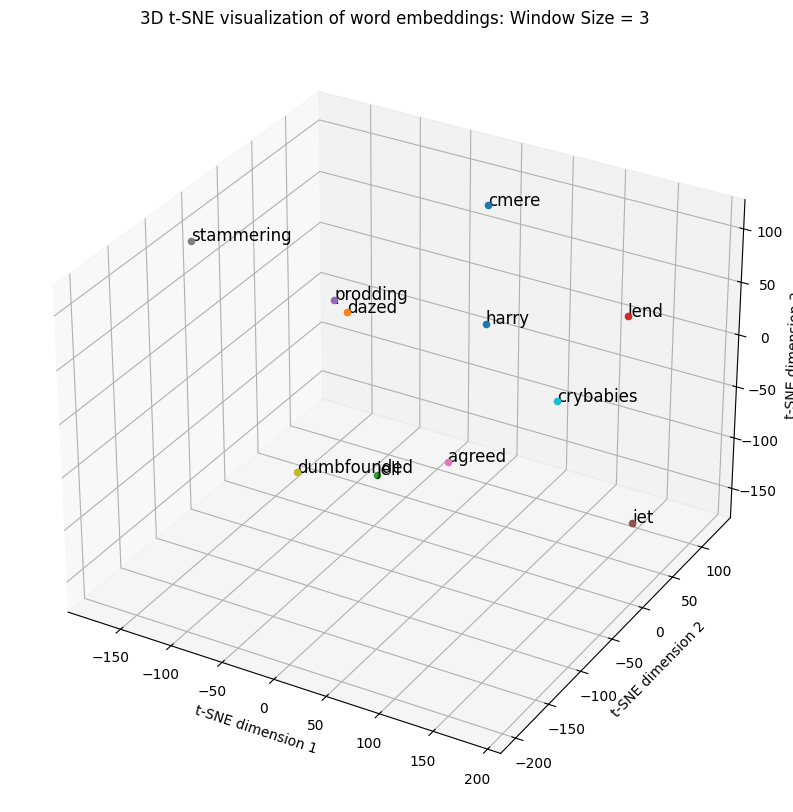

In [12]:
# Plotting the results
words, similarities = zip(*top_related_words)

plt.figure(figsize=(10, 6))
plt.barh(words, similarities, color='skyblue')
plt.xlabel('Cosine Similarity')
plt.title(f'Top 10 Related Words to "{target_word}": Window Size = 3')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest similarity on top
plt.show()


# Prepare data for t-SNE
words = [target_word] + [word for word, _ in top_related_words]
word_embeddings = np.array([get_embedding(word) for word in words])

# Apply t-SNE with adjusted perplexity
perplexity = min(30, len(words) - 1)  # Perplexity should be less than the number of samples
tsne = TSNE(n_components=3, perplexity=perplexity, random_state=42)
word_embeddings_3d = tsne.fit_transform(word_embeddings)

# Plot the t-SNE visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for i, word in enumerate(words):
    ax.scatter(word_embeddings_3d[i, 0], word_embeddings_3d[i, 1], word_embeddings_3d[i, 2])
    ax.text(word_embeddings_3d[i, 0], word_embeddings_3d[i, 1], word_embeddings_3d[i, 2], word, fontsize=12)

ax.set_title('3D t-SNE visualization of word embeddings: Window Size = 3')
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')
ax.set_zlabel('t-SNE dimension 3')
plt.show()

## Increase window size

### Window size = 5

In [13]:
window_size = 5
X, y = generate_training_data(corpus, word_to_idx, window_size)

In [14]:
vocab_size = len(unique_words)
embedding_dim = 100  # Dimension of the embedding vectors

initializer = tf.keras.initializers.RandomNormal(mean=0.05, stddev=0.05)
# Define the model
input_layer = tf.keras.layers.Input(shape=(1,))
embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1)(input_layer)
hidden_layer = tf.keras.layers.Dense(128, activation=None, kernel_initializer = initializer)(embedding_layer)
dropout_layer = tf.keras.layers.Dropout(0.5)(hidden_layer)
flatten_layer = tf.keras.layers.Flatten()(hidden_layer)
output_layer = tf.keras.layers.Dense(vocab_size, activation='softmax', kernel_initializer = initializer)(flatten_layer)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model.fit(X_train, y_train, epochs=20, batch_size=40, validation_data=(X_test, y_test))

print("Model training completed.")


Epoch 1/20


/home/zachs/.local/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


8471/8471 [==============================] - 67s 8ms/step - loss: 6.5657 - accuracy: 0.0473 - val_loss: 6.4826 - val_accuracy: 0.0479
Epoch 2/20
8471/8471 [==============================] - 66s 8ms/step - loss: 6.3962 - accuracy: 0.0497 - val_loss: 6.4186 - val_accuracy: 0.0484
Epoch 3/20
8471/8471 [==============================] - 66s 8ms/step - loss: 6.2441 - accuracy: 0.0520 - val_loss: 6.4068 - val_accuracy: 0.0482
Epoch 4/20
8471/8471 [==============================] - 66s 8ms/step - loss: 6.1006 - accuracy: 0.0521 - val_loss: 6.4258 - val_accuracy: 0.0453
Epoch 5/20
8471/8471 [==============================] - 63s 7ms/step - loss: 5.9908 - accuracy: 0.0510 - val_loss: 6.4651 - val_accuracy: 0.0429
Epoch 6/20
8471/8471 [==============================] - 67s 8ms/step - loss: 5.9124 - accuracy: 0.0502 - val_loss: 6.4918 - val_accuracy: 0.0436
Epoch 7/20
8471/8471 [==============================] - 68s 8ms/step - loss: 5.8562 - accuracy: 0.0493 - val_loss: 6.5226 - val_accuracy: 0.0

In [15]:
embedding_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(index=1).output)
embeddings = embedding_model.get_weights()[0]  # Get the weights of the embedding layer

target_word = "harry"
top_related_words = get_most_similar_words(target_word, top_n=10)

print(f"Top related words to '{target_word}':")
for word, similarity in top_related_words:
    print(f"{word}: {similarity:.4f}")


Top related words to 'harry':
pompously: 0.3490
west: 0.2606
uncertainly: 0.2547
know: 0.2383
lightest: 0.2301
handsome: 0.2269
somehow: 0.2248
ron: 0.2208
boil: 0.2156
paws: 0.2146


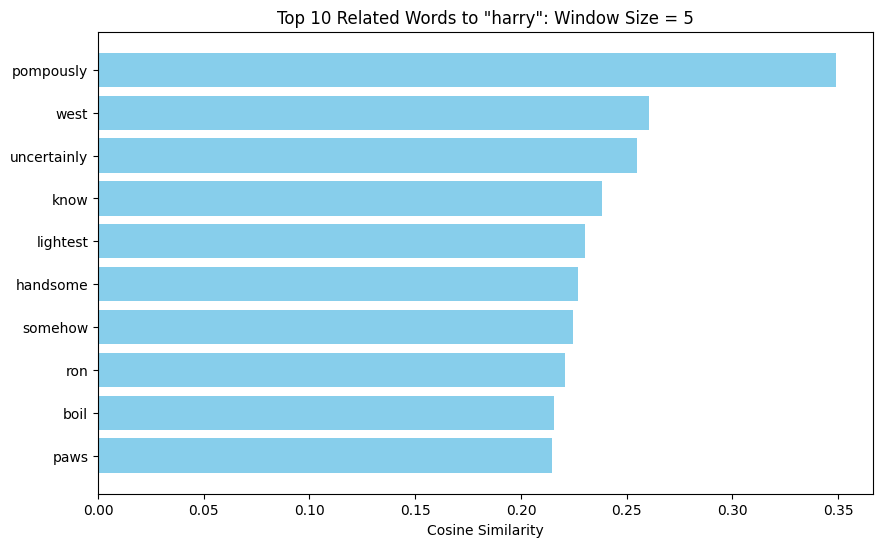

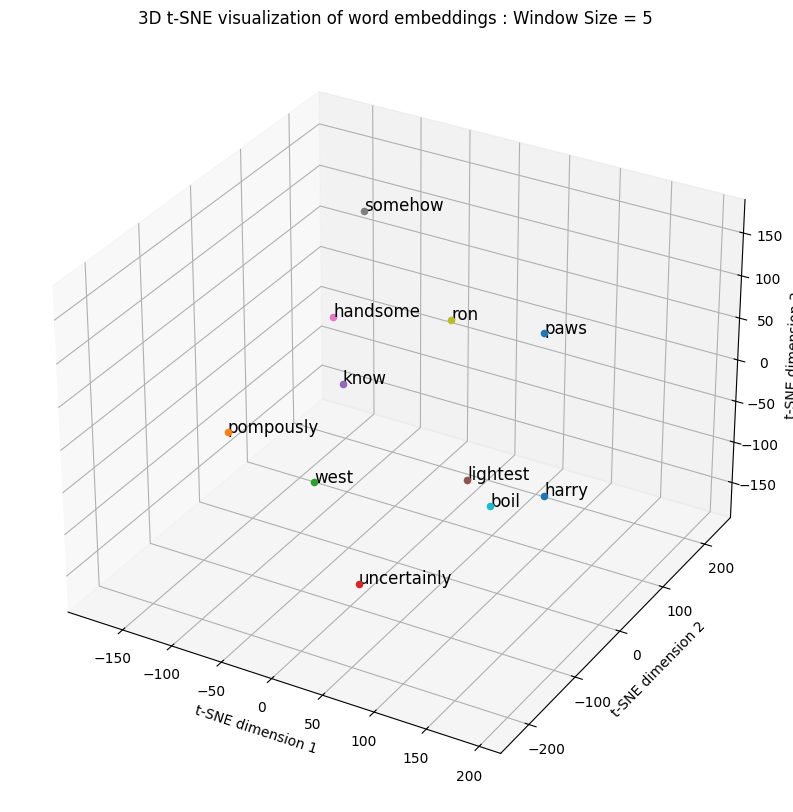

In [16]:
# Plotting the results
words, similarities = zip(*top_related_words)

plt.figure(figsize=(10, 6))
plt.barh(words, similarities, color='skyblue')
plt.xlabel('Cosine Similarity')
plt.title(f'Top 10 Related Words to "{target_word}": Window Size = 5')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest similarity on top
plt.show()


# Prepare data for t-SNE
words = [target_word] + [word for word, _ in top_related_words]
word_embeddings = np.array([get_embedding(word) for word in words])

# Apply t-SNE with adjusted perplexity
perplexity = min(30, len(words) - 1)  # Perplexity should be less than the number of samples
tsne = TSNE(n_components=3, perplexity=perplexity, random_state=42)
word_embeddings_3d = tsne.fit_transform(word_embeddings)

# Plot the t-SNE visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for i, word in enumerate(words):
    ax.scatter(word_embeddings_3d[i, 0], word_embeddings_3d[i, 1], word_embeddings_3d[i, 2])
    ax.text(word_embeddings_3d[i, 0], word_embeddings_3d[i, 1], word_embeddings_3d[i, 2], word, fontsize=12)

ax.set_title('3D t-SNE visualization of word embeddings : Window Size = 5')
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')
ax.set_zlabel('t-SNE dimension 3')
plt.show()